In [1]:
import pandas as pd
import json

In [5]:
!pip install networkx matplotlib


In [3]:
# Load the JSON (replace this with your own loading if reading from a file)
with open("./data/dreps_data_adastat.json", "r") as f:
    json_data = json.load(f)

# Convert the "rows" part into a DataFrame
df = pd.DataFrame(json_data["rows"])

# Save to CSV
df.to_csv("drep_data.csv", index=False)

In [6]:
#load csv
df = pd.read_csv("./data/drep_data.csv")
df.columns

Index(['hash', 'bech32_legacy', 'has_script', 'tx_hash', 'url', 'comment',
       'payment_address', 'given_name', 'objectives', 'motivations',
       'qualifications', 'image', 'live_stake', 'delegator', 'tx_time',
       'last_active_epoch', 'bech32'],
      dtype='object')

/var/folders/vb/cd5tlbwj1gg4b3zk4dtfg1th0000gq/T/ipykernel_24516/4022918110.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/Joel/Documents/GitHub/ada_drep/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32645 (\N{CJK UNIFIED IDEOGRAPH-7F85}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Joel/Documents/GitHub/ada_drep/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36993 (\N{CJK UNIFIED IDEOGRAPH-9081}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Joel/Documents/GitHub/ada_drep/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20977 (\N{CJK UNIFIED IDEOGRAPH-51F1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Joel/Documents/GitHub/ada_drep/.venv/lib/python3.12/site-pa

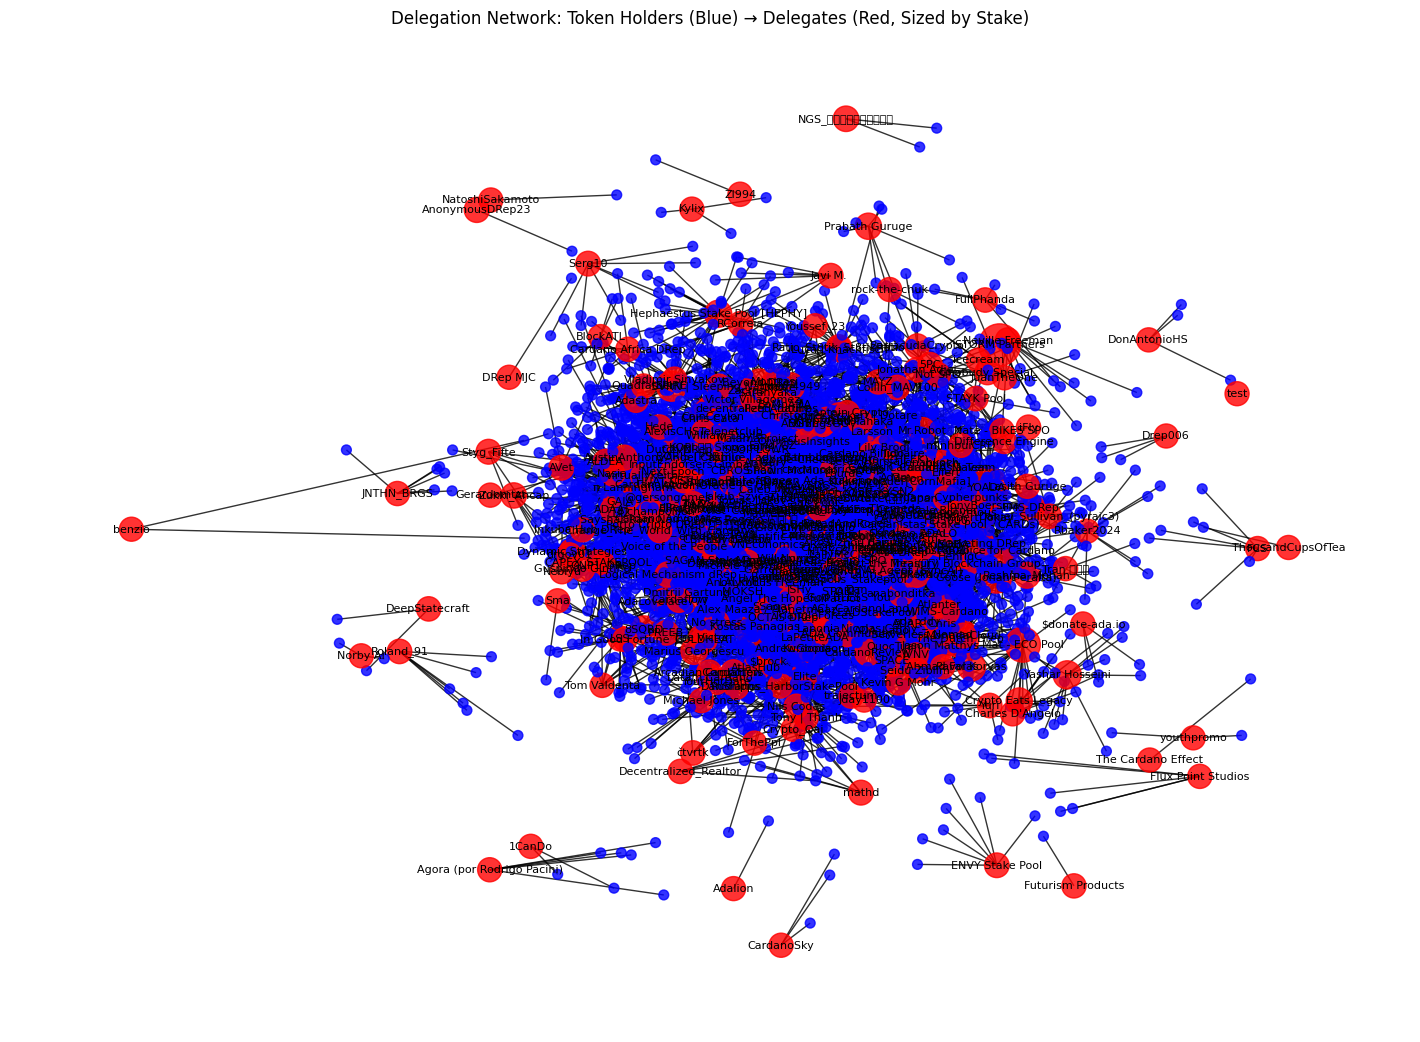

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load your CSV (adjust path as needed)
df = pd.read_csv("./data/drep_data.csv")

# Convert columns to numeric
df['live_stake'] = pd.to_numeric(df['live_stake'], errors='coerce')
df['delegator'] = pd.to_numeric(df['delegator'], errors='coerce')

# Create a directed graph
G = nx.DiGraph()

# Normalize live stake for visual sizing
max_stake = df['live_stake'].max()

for idx, row in df.iterrows():
    delegate = row['given_name']
    live_stake = row['live_stake']
    num_delegators = int(row['delegator'])

    # Add delegate node (in red), size by stake
    G.add_node(delegate, color='red', size=300 + 700 * (live_stake / max_stake))

    # Add simulated delegators (in blue) and connect to delegate
    for j in range(num_delegators):
        delegator = f"holder_{idx}_{j}"
        G.add_node(delegator, color='blue', size=50)
        G.add_edge(delegator, delegate)

# Draw the graph
colors = [G.nodes[n]['color'] for n in G.nodes]
sizes = [G.nodes[n]['size'] for n in G.nodes]

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.4)
nx.draw(G, pos, with_labels=False, node_color=colors, node_size=sizes, alpha=0.8, arrows=False)

# Label only the DReps
labels = {n: n for n in G.nodes if G.nodes[n]['color'] == 'red'}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Delegation Network: Token Holders (Blue) → Delegates (Red, Sized by Stake)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
import requests
import time
from tqdm import tqdm

# Load your CSV with bech32_legacy addresses
df = pd.read_csv("./data/drep_data.csv")

# List to store all delegators' info
all_delegators = []

# Loop through each DRep and fetch delegators ("rows")
for _, row in tqdm(df.iterrows(), total=len(df)):
    bech32 = row["bech32_legacy"]
    url = f"https://adastat.net/api/rest/v1/dreps/{bech32}.json?rows=delegators&sort=live_stake&dir=desc&limit=1000&currency=usd"

    try:
        res = requests.get(url)
        if res.status_code == 200:
            json_data = res.json()
            delegator_rows = json_data.get("rows", [])
            for delegator in delegator_rows:
                delegator["drep_bech32"] = bech32  # Add DRep reference
                all_delegators.append(delegator)
        else:
            print(f"Failed for {bech32} - status {res.status_code}")
    except Exception as e:
        print(f"Error for {bech32}: {e}")
    time.sleep(1)  # Prevent rate limiting

# Save all delegator data to CSV
delegators_df = pd.DataFrame(all_delegators)
delegators_df.to_csv("drep_delegators.csv", index=False)


100%|██████████| 845/845 [29:04<00:00,  2.06s/it]


In [24]:
delegators_df

,hash,bech32,live_stake,tx_hash,tx_time,drep_bech32,from_bech32,from_hash,from_has_script,from_given_name,from_image
0,e16f4228aa5322bae35fd96558c1a52c38b54d649c13f4...,stake1u9h5y2922v3t4c6lm9j43sd99sut2ntynsflf4td...,2844423641069,f85e498da1648f5ef1c127dfecd2c2513b2f296963ee30...,1734535071,drep14qm80e579gf629ekr4snl7jrvxgr0qrqmg4aqgngg...,NaN,NaN,NaN,NaN,NaN
1,e19d0b0646bf7685cb16e45d24be1a68f8829e26cd2a49...,stake1uxwskpjxhamgtjcku3wjf0s6drug983xe54yjw95...,1547765682333,a8464b416bc15bdc71d00320398a6eb57b10bee9207ac3...,1737378585,drep14qm80e579gf629ekr4snl7jrvxgr0qrqmg4aqgngg...,NaN,NaN,NaN,NaN,NaN
2,e154e0ced9d883d25a5db3ccb74fe149fb8c15456a26de...,stake1u92wpnkemzpaykjak0xtwnlpf8acc929dgndacxn...,278980401407,6e93e1542daf70c41e96882c300a165ba60e9b9e1cea03...,1731111433,drep14qm80e579gf629ekr4snl7jrvxgr0qrqmg4aqgngg...,NaN,NaN,NaN,NaN,NaN
3,e14b9c7524d676356ad06536e54dc62fda4ca4cc1730d1...,stake1u99ecafy6emr26ksv5mw2nwx9ldyefxvzucdzh5k...,250501373092,376ff1530909baf79d4f8a039b5b469eb496ab8218ba89...,1725495792,drep14qm80e579gf629ekr4snl7jrvxgr0qrqmg4aqgngg...,NaN,NaN,NaN,NaN,NaN
4,e1c1b677e9a75ec6de332c4ede3b99bbb552c73b829fd2...,stake1u8qmvalf5a0vdh3n938duwuehw6493ems20a9svt...,250349252710,1c64a9d646afa03b5fb103c9e6e5e3441d80b67642be40...,1725495471,drep14qm80e579gf629ekr4snl7jrvxgr0qrqmg4aqgngg...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7559,e16e039ef9fa1c145d951b4b983e07685250afb6d2f575...,stake1u9hq88helgwpghv4rd9es0s8dpf9ptak6t6htye6...,1951631,34baad15df962afd242d1177b6a42e38c17a363d249e26...,1725895701,drep1phescp0plhtdvh55jv5yghheddpfx43x3y8d9dw8s...,drep_always_no_confidence,NaN,NaN,NaN,NaN
7560,e13ad800018925039bf33f28af934eafdbea294c4b6157...,stake1uyadsqqp3yjs8xln8u52ly6w4ld7522vfds40px4...,1878807,225f90036496671a80849436978c04db077ac86b44c276...,1732245146,drep1aaa7vvrlzcnvryjxy9cq346fksygppew3ylm999y7...,NaN,NaN,NaN,NaN,NaN
7561,e1ebb50a89ba0c0e56144024fca66b8b88ce7de8a9ab71...,stake1u84m2z5fhgxqu4s5gqj0efnt3wyvul0g4x4hzypd...,1300233,2d6a91a4162eeaf518f8a487cc3beaf29aac227dff960e...,1725231543,drep15v2a3djn6jp0efdr7q5ym9gndzj3gs83mtj0ngcvm...,NaN,NaN,NaN,NaN,NaN
7562,e194917a8771d16a6f0ecfdc53882dbd69710105e07093...,stake1ux2fz758w8gk5mcwelw98zpdh45hzqg9upcf8pl6...,1019886,e15368a28b2a7ab5901a97f4e8834f4c1c1c875bbaa9cc...,1738656459,drep1f0j4sa2079eh3j3c04gws4sdzkatrtmk6l5zes3xc...,NaN,NaN,NaN,NaN,NaN


In [27]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load data
df = delegators_df  # columns: bech32, live_stake, drep_bech32

# Convert live_stake to numeric if not already
df["live_stake"] = pd.to_numeric(df["live_stake"], errors='coerce').fillna(0)

# Create graph
G = nx.DiGraph()

# Add edges and delegator nodes (blue)
for _, row in df.iterrows():
    delegator = row["bech32"]
    drep = row["drep_bech32"]
    stake = row["live_stake"]

    G.add_node(delegator, color='blue', size=max(stake / 1e9, 1))  # scaled size, min size=1
    G.add_node(drep, color='red')  # we’ll set size later
    G.add_edge(delegator, drep)

# Calculate DRep sizes based on total delegated stake
drep_sizes = df.groupby("drep_bech32")["live_stake"].sum().to_dict()
for node in G.nodes():
    if G.nodes[node].get("color") == "red":
        stake = drep_sizes.get(node, 0)
        G.nodes[node]["size"] = max(stake / 1e9, 5)  # scaled size, min size=5

# Get node attributes
colors = [G.nodes[n]["color"] for n in G.nodes()]
sizes = [G.nodes[n]["size"] for n in G.nodes()]

# Layout
pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)

# Plot
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.2, arrows=False)
plt.axis('off')
plt.title("Delegation Graph: Delegators to DReps", fontsize=18)

# Save to PDF
plt.savefig("delegation_graph.pdf", format="pdf", bbox_inches='tight')
plt.close()


/var/folders/vb/cd5tlbwj1gg4b3zk4dtfg1th0000gq/T/ipykernel_24516/2283046374.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


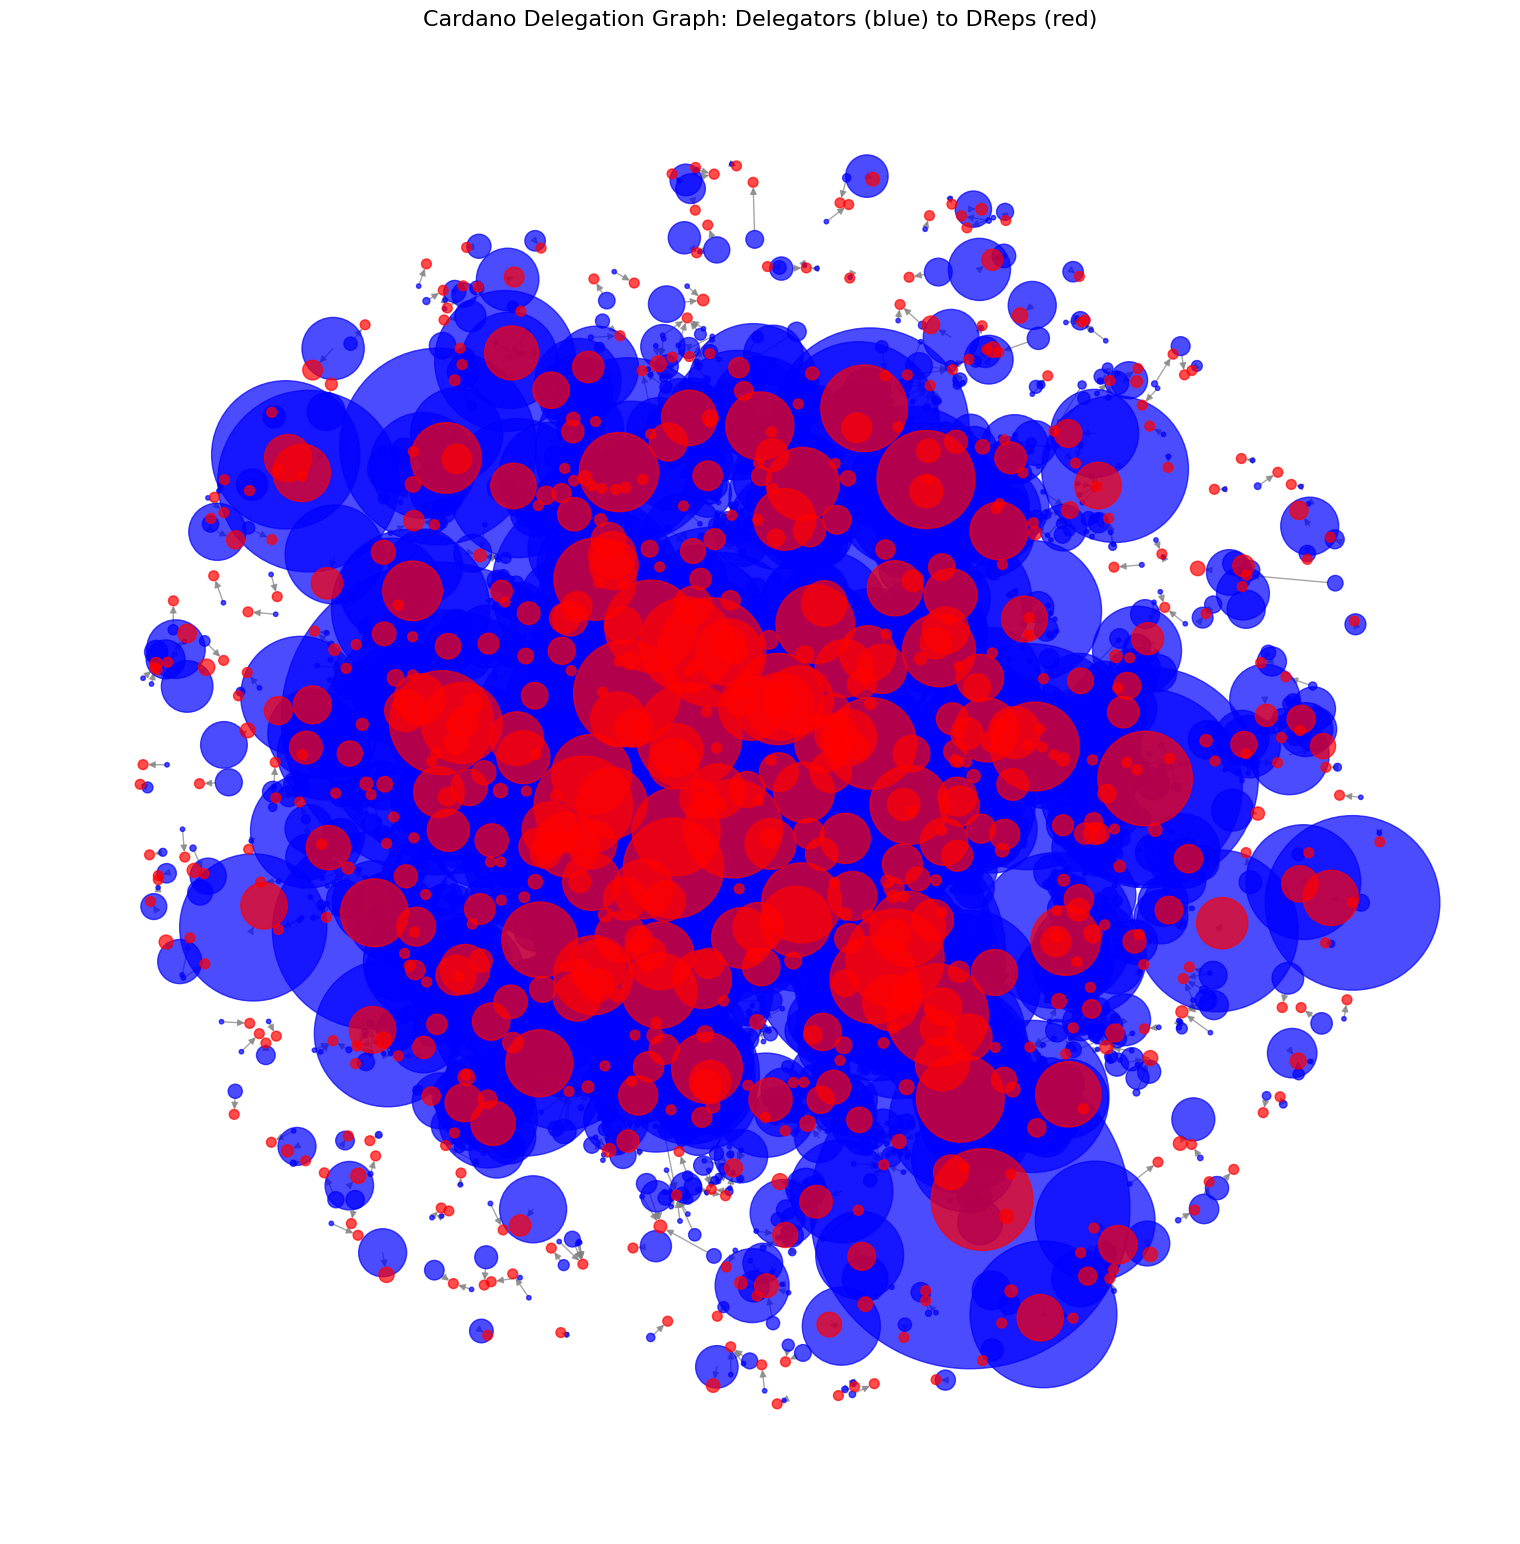

In [26]:
# Plot using spring layout
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.3, iterations=50)
nx.draw(G, pos, node_color=colors, node_size=sizes, edge_color='gray', alpha=0.7, with_labels=False)
plt.title("Cardano Delegation Graph: Delegators (blue) to DReps (red)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()